In [14]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import pickle
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns

# set device to gpu
device = (
"cuda"
if torch.cuda.is_available()
else "mps"
if torch.backends.mps.is_available()
else "cpu"
)
device

'cuda'

In [15]:
tfidf_train_data = pd.read_csv('../Data/TrainingData/tfidf_train.csv')
tfidf_val_data = pd.read_csv('../Data/ValidateData/tfidf_val.csv')
word2vec_train_data = pd.read_csv('../Data/TrainingData/word2vec_train.csv')
word2vec_val_data = pd.read_csv('../Data/ValidateData/word2vec_val.csv')
bert_train_data = pd.read_csv('../Data/TrainingData/bert_train.csv')
bert_val_data = pd.read_csv('../Data/ValidateData/bert_val.csv')

In [16]:
def separator(count = 50):
    print('-'*count)

def train_rf_model(df, model_path, scaler_path):
    data = df.copy()
    y = data.pop('source')  # 假設標籤列名為 'label'
    
    # 標準化數據
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data.values)
    # 保存標準化器
    joblib.dump(scaler, scaler_path)

    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


    model = RandomForestClassifier()

    model.fit(X_train, y_train)

    cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    print(cv_scores)

    # score train and test sets
    scoreTrain = model.score(X_train, y_train)
    scoreTest = model.score(X_test, y_test)

    # predict the train and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    cm_train_result = confusion_matrix(y_train, y_pred_train)
    cm_test_result = confusion_matrix(y_test, y_pred_test)
    cr_result = classification_report(y_test,y_pred_test)

    model_name = str(model).split('(')[0]

    # print model name in blue color
    print('\033[1m' + model_name + '\033[0m')
    # print -----------------------------------
    separator()
    print('Train Score for '+str(model_name)+': ', (scoreTrain))
    separator()
    print('Test Score for '+str(model_name)+': ', (scoreTest))
    separator()
    print('Confusion Matrix for '+str(model_name)+' for test : \n', (cm_test_result))
    separator()
    print('Classification Report for '+str(model_name)+' for test : \n', str(cr_result))
    separator()

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm_train_result, annot=True, fmt='d', ax=ax[0], cmap='Blues')
    ax[0].set_title('Train Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')

    sns.heatmap(cm_test_result, annot=True, fmt='d', ax=ax[1], cmap='Blues')
    ax[1].set_title('Test Confusion Matrix')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Actual')

    # feature_importance = np.array(model.feature_importances_)
    # print(len(list(data.iloc[:, :-1].columns)))
    # print(len(feature_importance))
    # rank_of_coef = pd.DataFrame({'coef_name': list(data.columns), 'feature_importance': feature_importance })
    # print(rank_of_coef.sort_values(by=['feature_importance'], ascending=False).head(n=20))
    # 保存整個模型
    pickle.dump(model, open(model_path, 'wb'))
    return model, scaler

In [17]:
def evaluate_on_new_data(model, scaler, new_data):
    data = new_data.copy()
    y_new = data.pop('source')
    X_new_scaled = scaler.transform(data.values)

    
    y_pred_new = model.predict(X_new_scaled)

    new_f2 = fbeta_score(y_new, y_pred_new, beta=2)
    cm_new = confusion_matrix(y_new, y_pred_new)

    print(f'New Data F2 Score: {new_f2:.4f}')

    # confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix on New Data')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

[1.         0.99224806 0.99224806 1.         0.99610895]
RandomForestClassifier
--------------------------------------------------
Train Score for RandomForestClassifier:  1.0
--------------------------------------------------
Test Score for RandomForestClassifier:  0.9968944099378882
--------------------------------------------------
Confusion Matrix for RandomForestClassifier for test : 
 [[156   1]
 [  0 165]]
--------------------------------------------------
Classification Report for RandomForestClassifier for test : 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       157
           1       0.99      1.00      1.00       165

    accuracy                           1.00       322
   macro avg       1.00      1.00      1.00       322
weighted avg       1.00      1.00      1.00       322

--------------------------------------------------
New Data F2 Score: 1.0000


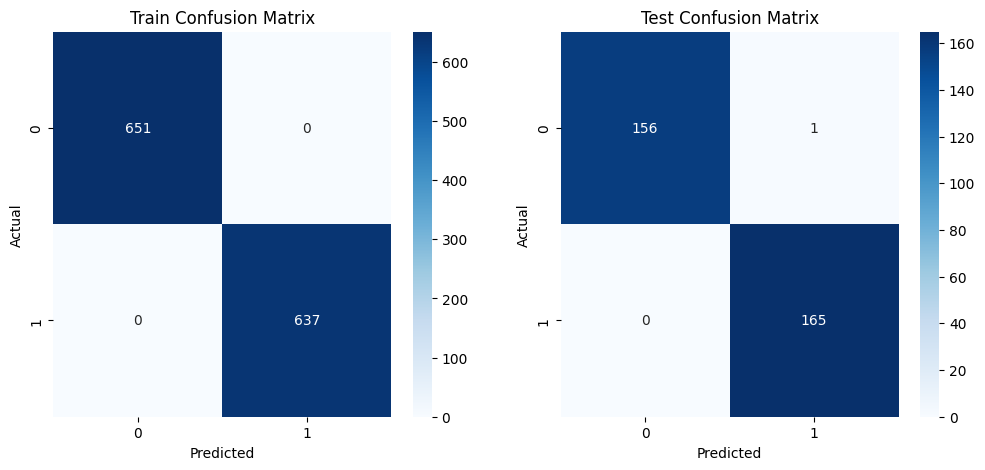

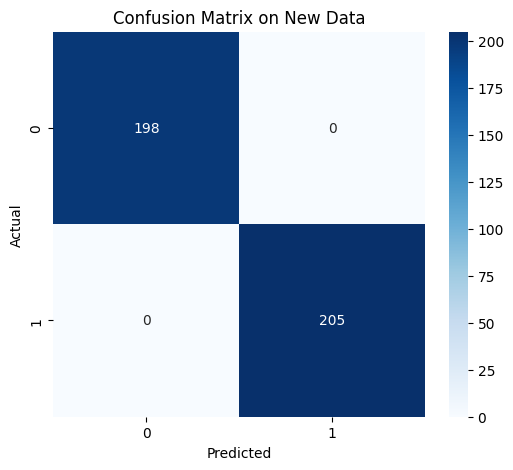

In [18]:
model, scaler = train_rf_model(tfidf_train_data, '../Data/Model/tfidf_rf_model.pkl', '../Data/Model/tfidf_rf_scaler.pkl')
evaluate_on_new_data(model, scaler,  tfidf_val_data)

[0.98449612 0.96124031 0.96511628 0.9766537  0.97276265]
RandomForestClassifier
--------------------------------------------------
Train Score for RandomForestClassifier:  1.0
--------------------------------------------------
Test Score for RandomForestClassifier:  0.9782608695652174
--------------------------------------------------
Confusion Matrix for RandomForestClassifier for test : 
 [[155   2]
 [  5 160]]
--------------------------------------------------
Classification Report for RandomForestClassifier for test : 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       157
           1       0.99      0.97      0.98       165

    accuracy                           0.98       322
   macro avg       0.98      0.98      0.98       322
weighted avg       0.98      0.98      0.98       322

--------------------------------------------------
New Data F2 Score: 0.9629


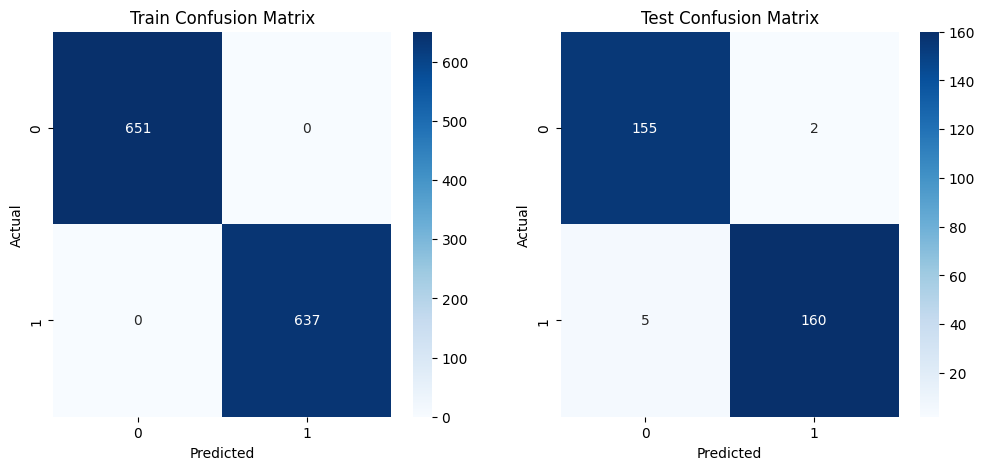

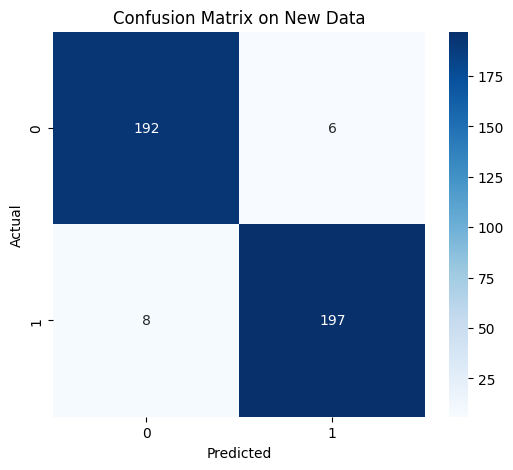

In [19]:
model, scaler = train_rf_model(word2vec_train_data, '../Data/Model/word2vec_rf_model.pkl', '../Data/Model/word2vec_rf_scaler.pkl')
evaluate_on_new_data(model, scaler, word2vec_val_data)

[0.99224806 0.99224806 0.99224806 0.99610895 0.98832685]
RandomForestClassifier
--------------------------------------------------
Train Score for RandomForestClassifier:  1.0
--------------------------------------------------
Test Score for RandomForestClassifier:  1.0
--------------------------------------------------
Confusion Matrix for RandomForestClassifier for test : 
 [[157   0]
 [  0 165]]
--------------------------------------------------
Classification Report for RandomForestClassifier for test : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      1.00      1.00       165

    accuracy                           1.00       322
   macro avg       1.00      1.00      1.00       322
weighted avg       1.00      1.00      1.00       322

--------------------------------------------------
New Data F2 Score: 0.9990


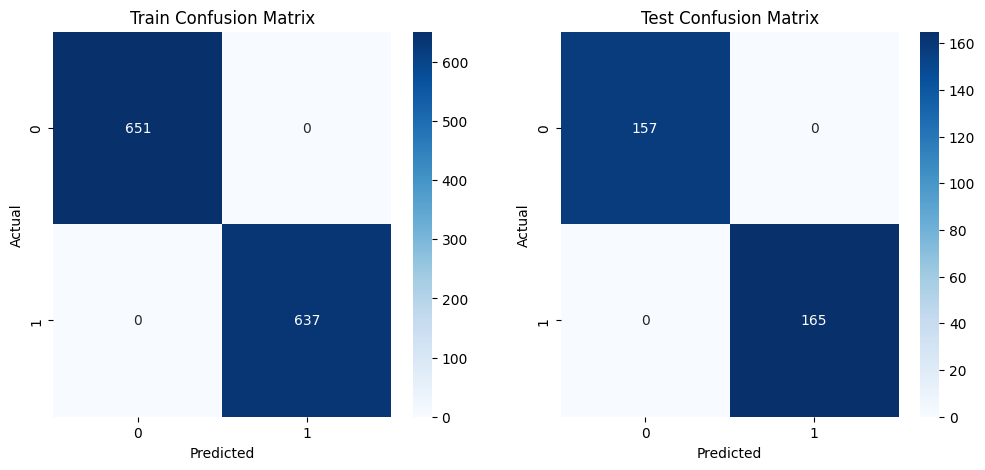

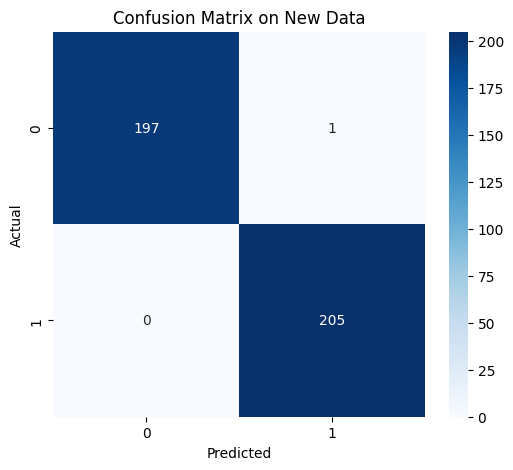

In [20]:
model, scaler = train_rf_model(bert_train_data, '../Data/Model/bert_rf_model.pkl', '../Data/Model/bert_rf_scaler.pkl')
evaluate_on_new_data(model, scaler, bert_val_data)